[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building MoGs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.10.4. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

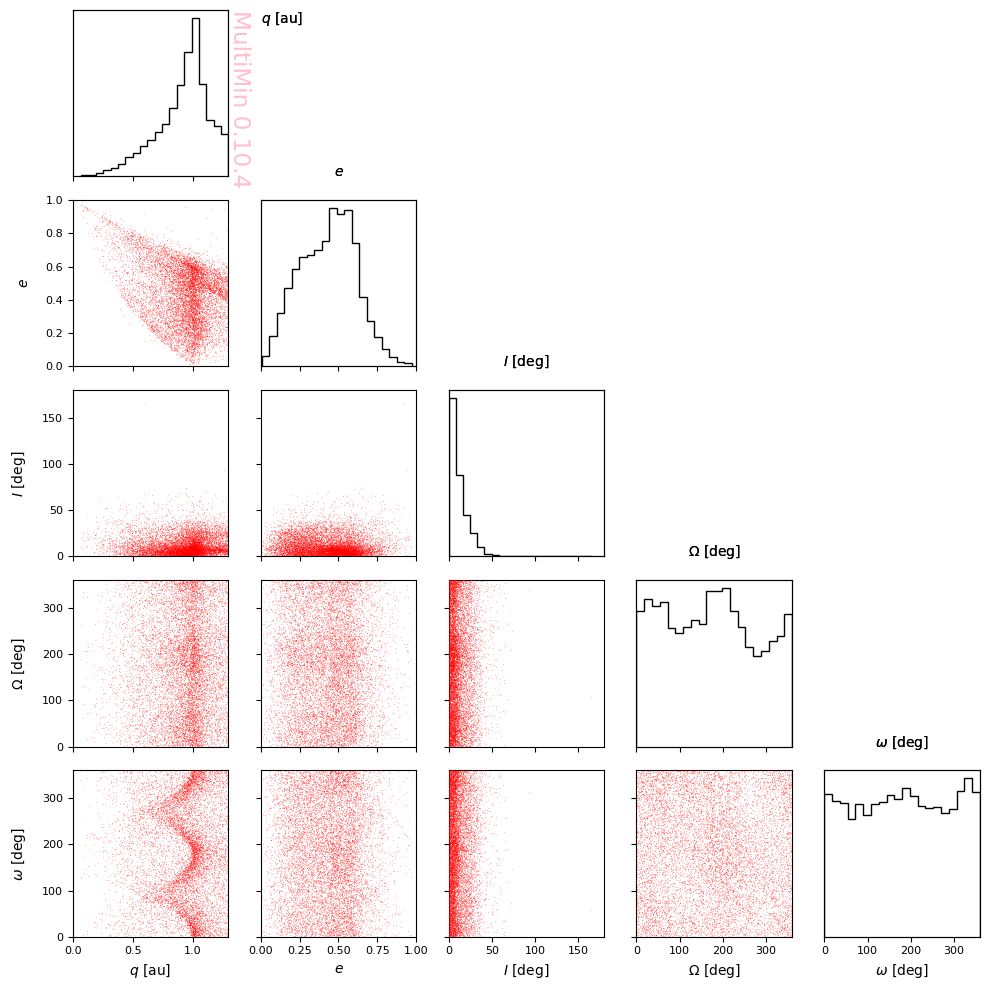

In [5]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.MultiPlot(properties,figsize=2,marginals=True)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [6]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

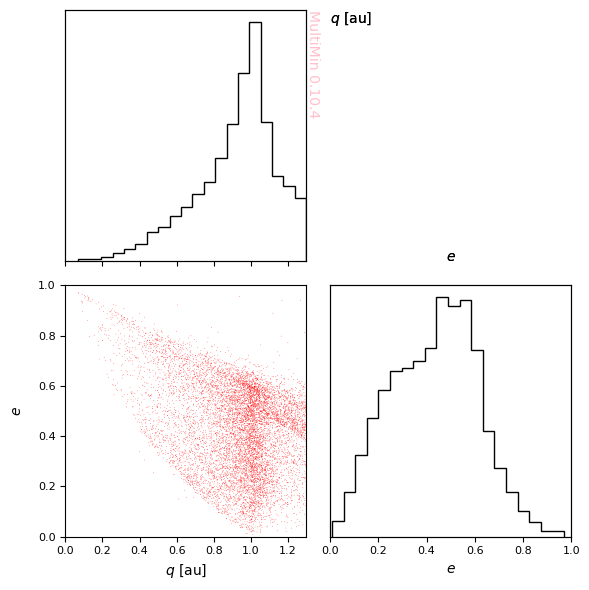

In [7]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.MultiPlot(properties,figsize=3,marginals=True)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [8]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitMoG(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(progress=False)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.30876007175183967
FitMoG.fit_data executed in 0.1638021469116211 seconds
Elapsed time since last call: 169.747 ms
-log(L)/N = -0.5434832568188299


And check the fit result:

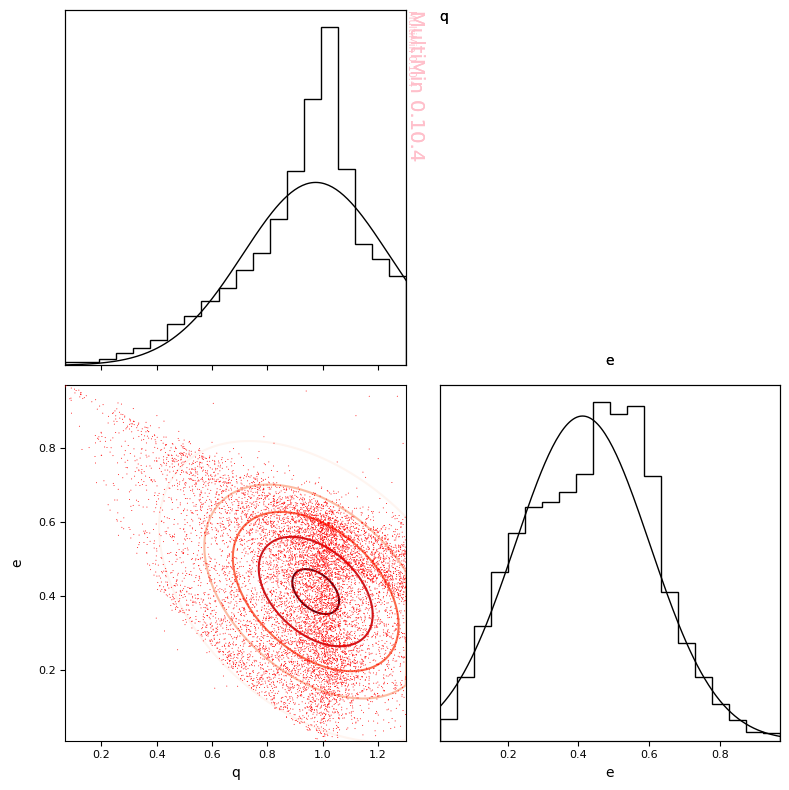

In [9]:
# properties: list of names or dict like MultiPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
pargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
cargs=dict()
G=F_qe_1.plot_fit(
    properties=properties,
    #pargs=hargs,
    pargs=None,
    sargs=sargs,
    cargs=cargs,
    figsize=4,
    marginals=True
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [10]:
F_qe_1.mog.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.974535,0.41181,0.263749,0.189947,-0.424838


We can do it better increasing the number of normals:

In [11]:
t = mn.Util.el_time(0)
F = mn.FitMoG(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data(advance=50)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 2
Number of dimensions: 10
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.24719135181808666
Iterations:
Iter 0:
	Vars: [-1.5, -1.3, -1.3, -1.3, -1.5, 0.49, 0.14, 0.82, 0.31, 0.96, 0.45, 1, 0.55, 1.2, 0.72, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, 0.71, 0.65, 0.74, 0.39, 1.1]
	LogL/N: 2.028570590830881
Iter 50:
	Vars: [-2.3, -1.1, -0.59, -1.1, -1.9, 0.64, 0.33, 0.98, 0.5, 0.99, 0.27, 1.1, 0.52, 1, 0.43, -4.3, -4.4, -3.4, -4.4, -4.3, -4.3, -3.1, -4.1, -5.1, -4.3, -2.1, -1.8, -0.38, -3.9, 0.51]
	LogL/N: -0.7119524367209009
Iter 100:
	Vars: [-2.3, -0.57, -0.93, -1.1, -2, 0.69, 0.27, 0.99, 0.47, 0.99, 0.24, 1.1, 0.52, 1, 0.47, -4.3, -4.5, -3.5, -4.4, -4.4, -4.5, -3.1, -4.1, -5.5, -4.5, -2.4, -1.1, -0.86, -3.9, 0.052]
	LogL/N: -0.7185576352269787
Iter 150:
	Vars: [-2.4, -0.26, -1.2, -0.91, -2.2, 0.72, 0.24, 0.96, 0.42, 0.99, 0.24, 1.3, 0.46, 1, 0.52, -4.1, -4.5,

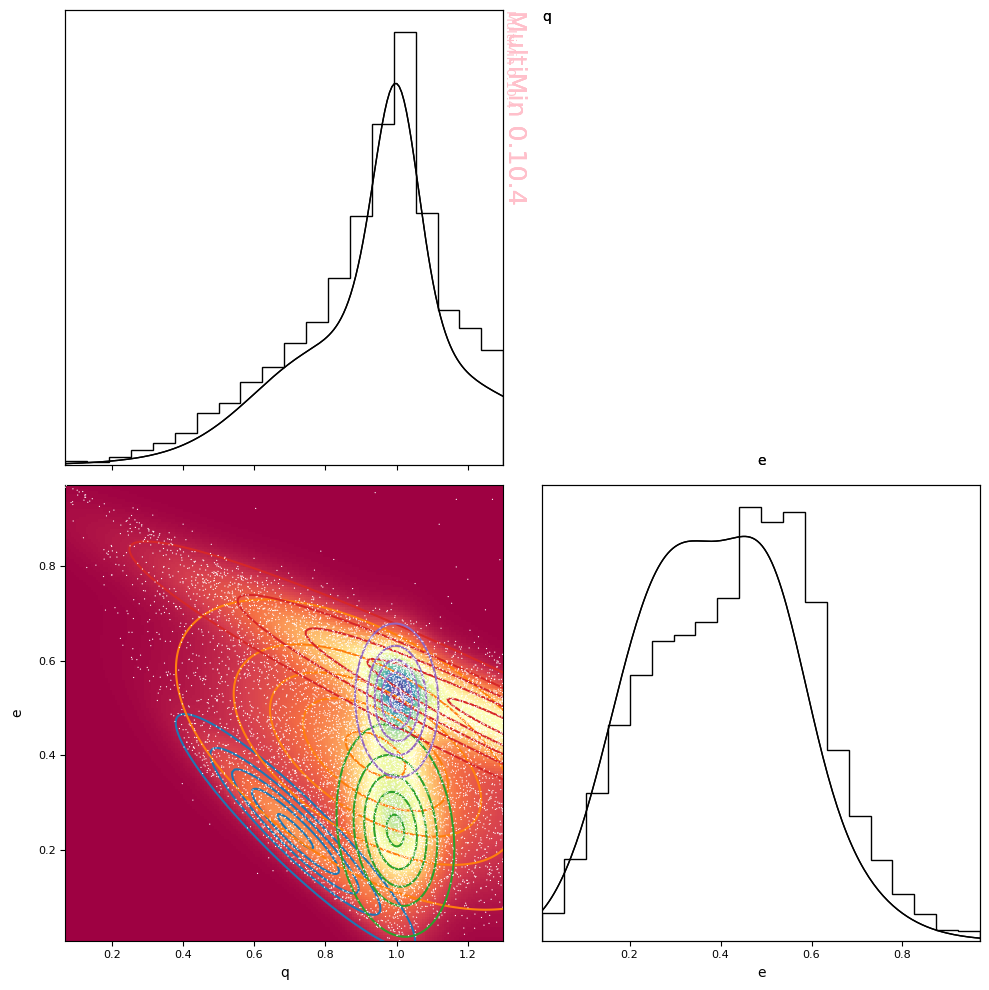

In [14]:
properties = ["q","e"]
sargs = dict(s=0.8,edgecolor='None',color='w')
pargs = dict(cmap='Spectral')
cargs = dict(decomp=True, legend=False)
G=F.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    cargs=cargs,
    figsize=5,
    marginals=True
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_decomposition.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [15]:
neas_sample = F.mog.rvs(len(data_neas_qe))

MixtureOfGaussians.rvs executed in 0.6680150032043457 seconds


And plot it:

Text(0.5, 1.0, 'Original data')

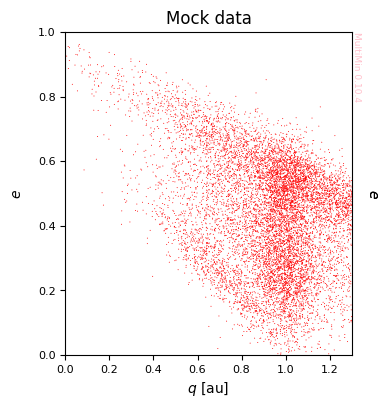

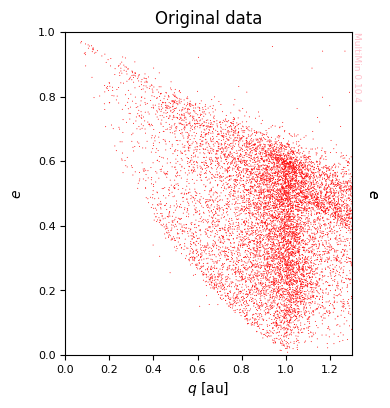

In [16]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.MultiPlot(properties,figsize=4)
G.sample_scatter(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.MultiPlot(properties,figsize=4)
scatter=G.sample_scatter(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [17]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.mog.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
2,0.375776,0.941086,0.401192,0.261131,0.152769,-0.552963
4,0.271414,1.300000,0.461571,0.489318,0.181844,-0.957204
3,0.178389,0.996898,0.240660,0.076939,0.104576,-0.167967
5,0.104043,1.000475,0.515575,0.054446,0.075778,-0.046803
1,0.070378,0.715968,0.238885,0.156532,0.115563,-0.926408


In [18]:
function, mog = F.mog.get_function(properties=properties)

import numpy as np
from multimin import Util

def mog(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.715968
    mu1_e = 0.238885
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.024502, -0.016758], [-0.016758, 0.013355]]
    Z1 = 0.980637
    n1 = Util.tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.941086
    mu2_e = 0.401192
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.068189, -0.022059], [-0.022059, 0.023338]]
    Z2 = 0.913492
    n2 = Util.tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 0.996898
    mu3_e = 0.24066
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.00592, -0.001351], [-0.001351, 0.010936]]
    Z3 = 0.989274
    n3 = Util.tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.3
    mu4_e = 0.461571
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.239432, -0.085172], [-0.085172, 0.033067]]
    Z4 = 0.495889
    n4 = Util.tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.000475
    mu5_e = 0.515575
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.002964, -0.000193], [-0.000193, 0.005742]]
    Z5 = 1

### Fitting other pair of properties

Fitting $q$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 180]]
Log-likelihood per point (-log L/N): 132.37480020628846
FitMoG.fit_data executed in 0.20511889457702637 seconds
-log(L)/N = 3.45731416220916


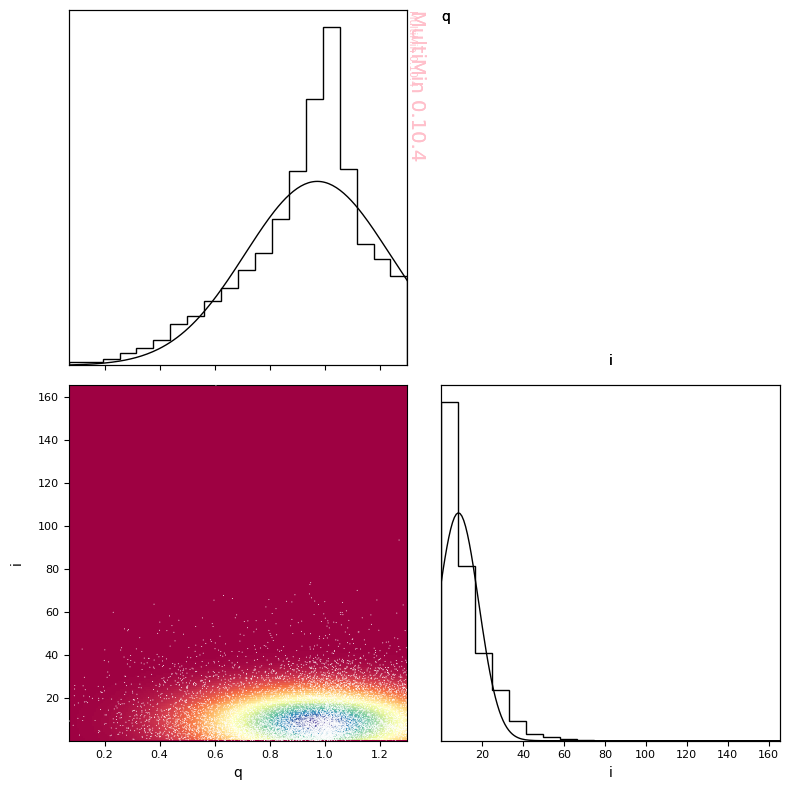

In [19]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitMoG(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(progress=False)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
sargs=dict(s=0.5,edgecolor='None',color='w')
pargs=dict(cmap='Spectral')
G=F_qi_1.plot_fit(properties=properties,pargs=pargs,sargs=sargs,figsize=4,marginals=True)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1], [0, 180]]
Log-likelihood per point (-log L/N): 135.19836019098284
FitMoG.fit_data executed in 0.2085719108581543 seconds
-log(L)/N = 3.297483624751035


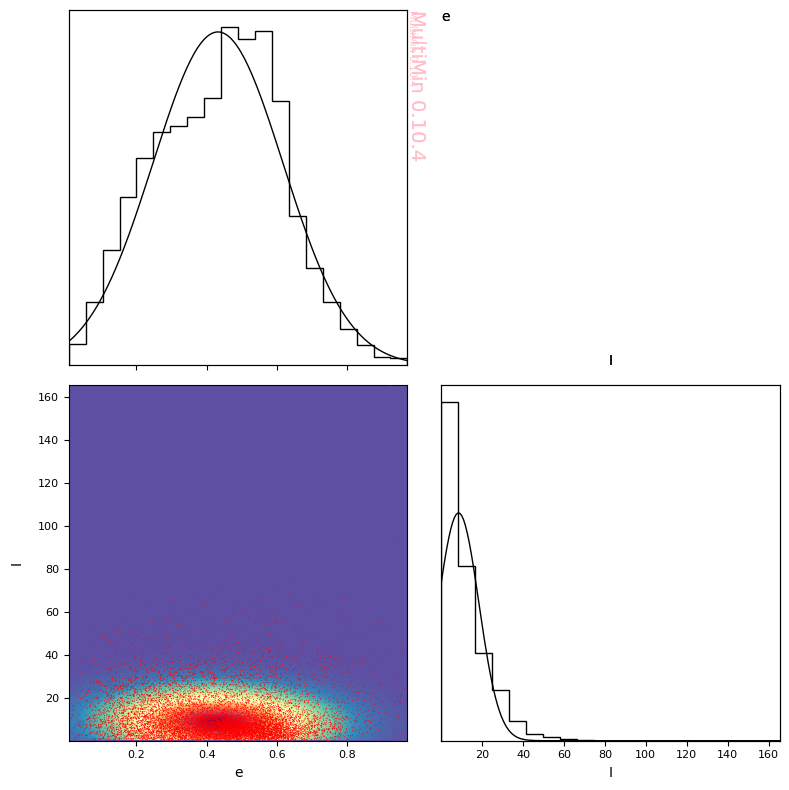

In [21]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitMoG(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(progress=False)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,sargs=sargs,figsize=4,marginals=True)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [22]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

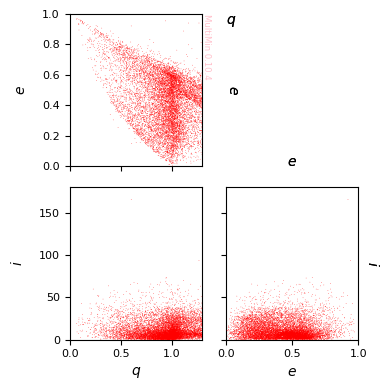

In [23]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.MultiPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.sample_scatter(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 145.53064945424399


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.5149061679840088 seconds
-log(L)/N = -1.5291267719093125


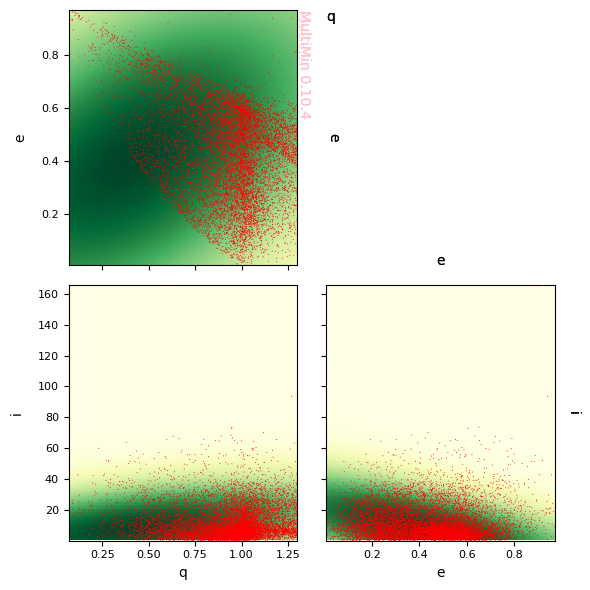

In [24]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    sargs=sargs,
    pargs=pargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

In [25]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.mog.mus[0, 0] + F_qi_1.mog.mus[0, 0]) / 2
mu_e = (F_qe_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 0]) / 2
mu_i = (F_qi_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 1]) / 2
sigma_q = (F_qe_1.mog.sigmas[0, 0] + F_qi_1.mog.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.mog.rhos[0, 0])
rho_qi = float(F_qi_1.mog.rhos[0, 0])
rho_ei = float(F_ei_1.mog.rhos[0, 0])

fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
#fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 145.53065027533523


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.3798956871032715 seconds
-log(L)/N = -2.3844556685254426


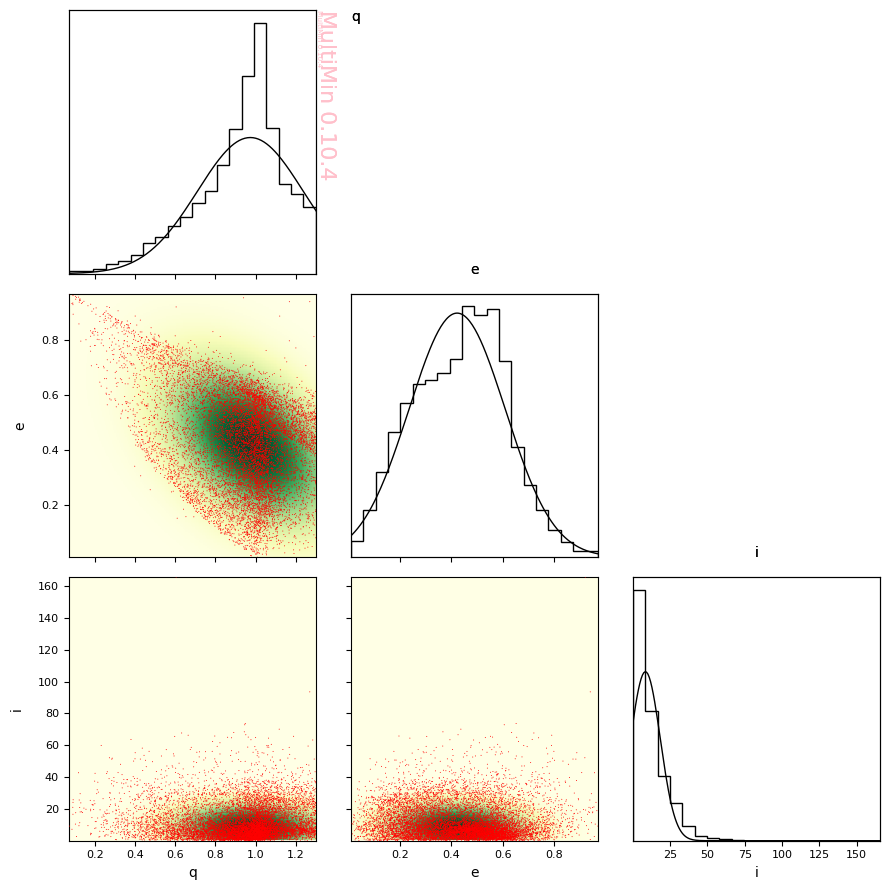

In [26]:
properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3,
    marginals=True
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Domain: [[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]]
Log-likelihood per point (-log L/N): 335.15915607536465


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 5.719875812530518 seconds


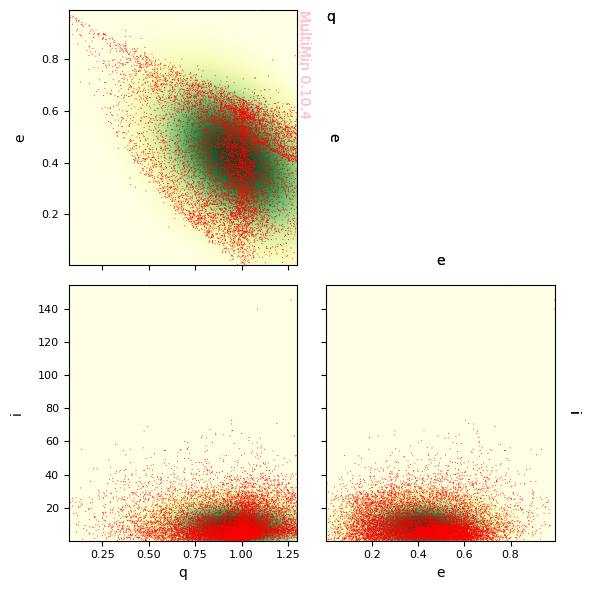

In [24]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(progress="tqdm")
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the MoG is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the MoG in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [27]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **MultiPlot** (scatter on pairwise panels):

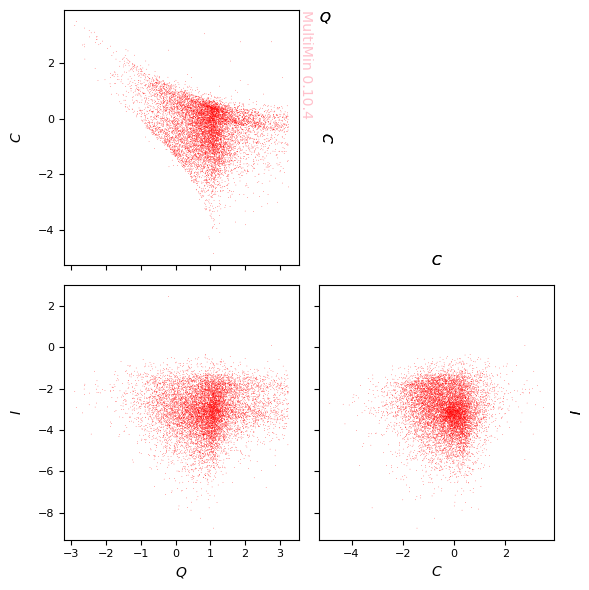

In [28]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.MultiPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

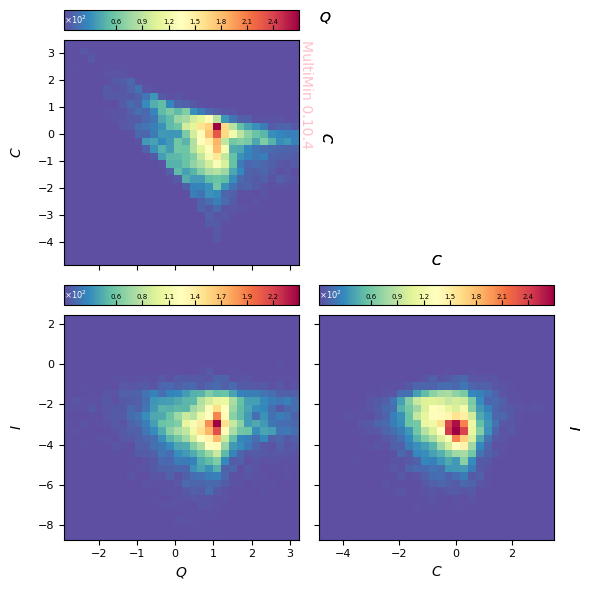

In [29]:
G=mn.MultiPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [30]:
F=mn.FitMoG(data=udata, ngauss=1)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.9550434674021


The fitter holds an initial MoG that will be optimized:

In [31]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.5, 0.5, 0.5]]
    Standard deviations (σ): [[1.0000000000000002, 1.0000000000000002, 1.0000000000000002]]
    Correlation coefficients (ρ): [[0.5, 0.5, 0.5]]

    Covariant matrices (Σ): 
        [[[1.0000000000000004, 0.5000000000000002, 0.5000000000000002], [0.5000000000000002, 1.0000000000000004, 0.5000000000000002], [0.5000000000000002, 0.5000000000000002, 1.0000000000000004]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000004, 0.5000000000000002, 0.5000000000000002, 1.0000000000000004, 0.5000000000000002, 1.0000000000000004]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000002, 1.0000000000000002, 1.000

Run the minimization:

In [32]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.1693868637084961 seconds
Elapsed time since last call: 170.228 ms
-log(L)/N = 3.9566415875052456


Inspect the fitted MoG:

In [33]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8710264746036992, -0.3371186224270384, -3.059120974182301]]
    Standard deviations (σ): [[0.8477360153246095, 0.8678852058178533, 1.0636775624173562]]
    Correlation coefficients (ρ): [[-0.3122205413450698, 0.037592612666335075, -0.07206824027491265]]

    Covariant matrices (Σ): 
        [[[0.7186563516784465, -0.22971237494347607, 0.03389792717600571], [-0.22971237494347607, 0.7532247304774976, -0.06652979746429709], [0.03389792717600571, -0.06652979746429709, 1.1314099567901288]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8710264746036992, -0.3371186224270384, -3.059120974182301, 0.7186563516784465, -0.22971237494347607, 0.03389792717600571, 0.7532247304774976, -0.06652979746429709, 1.1314099567901288]
        With std. and corre

Plot the fit result (fitted sample + data scatter):

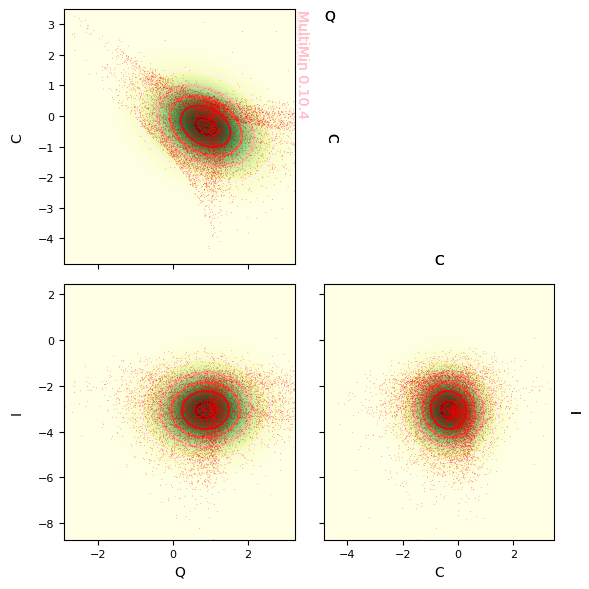

In [34]:
properties=["Q","C","I"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
cargs=dict()
G=F.plot_fit(properties=properties,sargs=sargs,cargs=cargs,pargs=pargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [35]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [36]:
F=mn.FitMoG(f"gallery/{figprefix}_fit-single.pkl")
print(F.mog)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 3.9566415875052456
Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8710264746036992, -0.3371186224270384, -3.059120974182301]]
    Standard deviations (σ): [[0.8477360153246095, 0.8678852058178533, 1.0636775624173562]]
    Correlation coefficients (ρ): [[-0.3122205413450698, 0.037592612666335075, -0.07206824027491265]]

    Covariant matrices (Σ): 
        [[[0.7186563516784465, -0.22971237494347607, 0.03389792717600571], [-0.22971237494347607, 0.7532247304774976, -0.06652979746429709], [0.03389792717600571, -0.06652979746429709, 1.1314099567901288]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8710264746036992, -0.33711862242703

Fit with two Gaussian components for a better likelihood:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.9550434674021


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 1.5737128257751465 seconds
Elapsed time since last call: 1.57387 s
-log(L)/N = 3.8445548659474698
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.3665629927757455, 0.6334370072242546]
    Number of variables: 3
    Averages (μ): [[0.9122667741299607, 0.3235471678364199, -2.997438747494376], [0.8007540533472284, -0.6926452805297898, -3.1059830434199442]]
    Standard deviations (σ): [[1.1198890503608598, 0.5653678542294612, 0.9064843641382123], [0.6349157983907938, 0.7986096258136935, 1.1430374987629215]]
    Correlation coefficients (ρ): [[-0.771951592132027, -0.03172292666921783, 0.056809394817848746], [-0.27012066206889374, 0.11030426916353676, -0.18429874680392377]]

    Covariant matrices (Σ): 
        [[[1.2541514851181486, -0.48876058655325905, -0.03220390694637666], [-0.48876058655325905, 0.31964081059602534, 0.029114651224306464], [-0.03220390694637666, 0.029114651224306464, 0.8217139024270591]], [[0.40

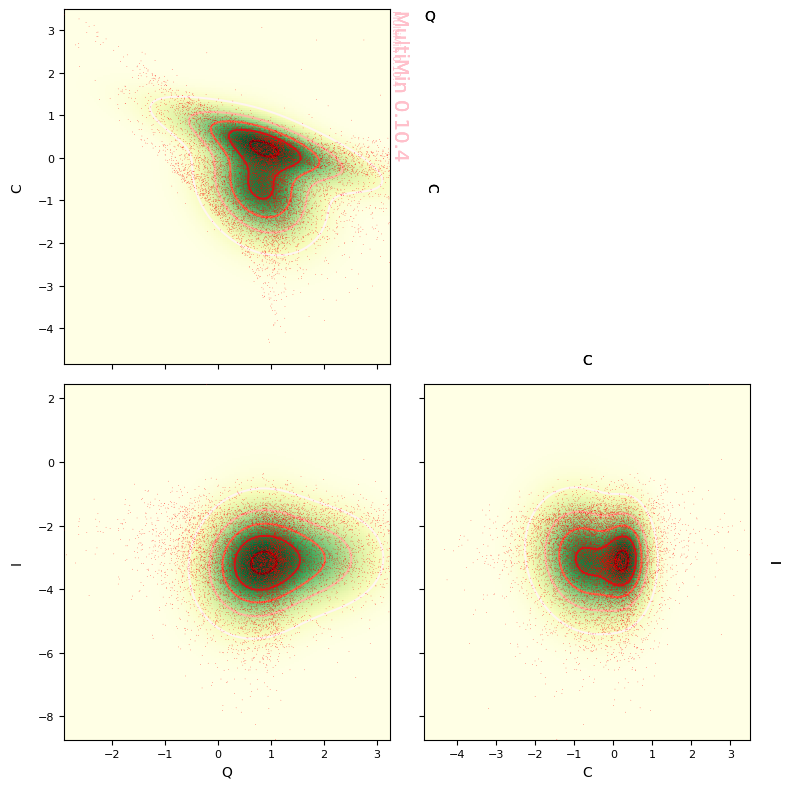

In [37]:
F=mn.FitMoG(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(progress="tqdm")
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.9550434674021


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 1.9251348972320557 seconds
Elapsed time since last call: 1.92555 s
-log(L)/N = 3.8481818401185564
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.3460640346624915, 0.6539359653375084]
    Number of variables: 3
    Averages (μ): [[0.7825150959874945, 0.36752552594967797, -2.925532157937501], [0.8259349102217848, -0.6647943787983195, -3.136457644853672]]
    Standard deviations (σ): [[1.1674171849047357, 0.5815446698342295, 0.8802888383680272], [0.6341830658854426, 0.801158920540248, 1.1431971695668652]]
    Correlation coefficients (ρ): [[-0.7701974767355464, -0.06902387718508907, 0.08971569511062771], [-0.23469810860962015, 0.12173349147294112, -0.21738826113303855]]

    Covariant matrices (Σ): 
        [[[1.3628628836108978, -0.5228911038335652, -0.07093337564487623], [-0.5228911038335652, 0.33819420301260295, 0.04592791193883627], [-0.07093337564487623, 0.04592791193883627, 0.7749084389553307]], [[0.4021881

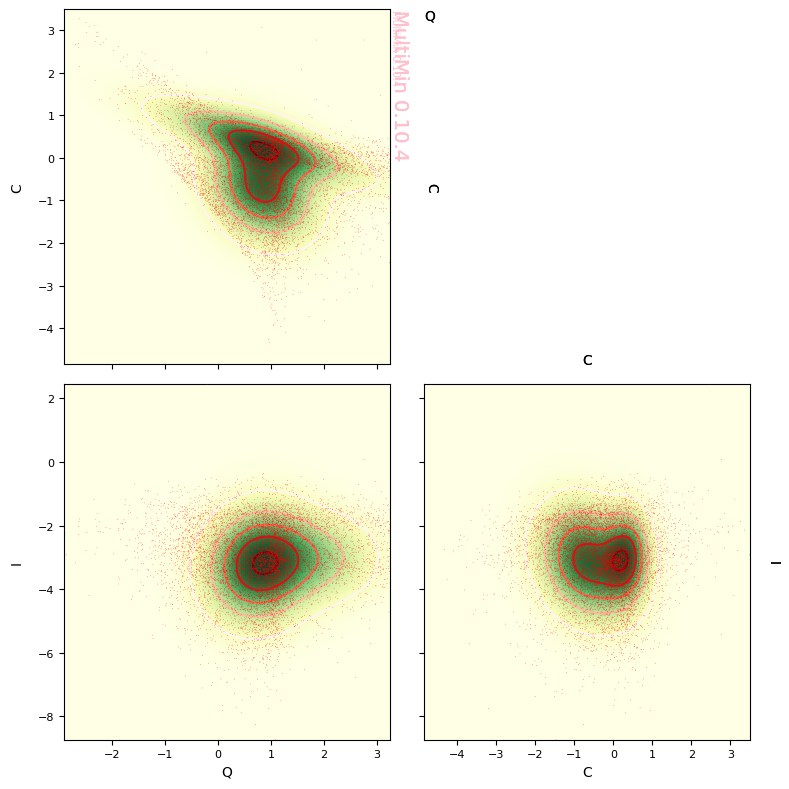

In [38]:
F=mn.FitMoG(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.9550434674021


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 18.703532934188843 seconds
Elapsed time since last call: 18.7304 s
-log(L)/N = 3.7111936823664773
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.04230285877717248, 0.14940385209640306, 0.28667565071827983, 0.2872265099164185, 0.23439112849172616]
    Number of variables: 3
    Averages (μ): [[1.7611753256309153, -0.42589645087052874, -4.129525467138507], [1.1357752843053721, -0.8360776004492064, -2.014680524593211], [1.163197756082329, 0.24968501368650742, -3.2246084526926397], [0.9676205461173075, -0.4649498738546241, -3.3800589115483395], [0.037109798348702185, -0.5195391661974422, -2.952547614520839]]
    Standard deviations (σ): [[0.898139098245963, 0.7640533452728192, 1.6304540759455877], [0.7854387090813154, 0.7562284387617468, 0.49013254712152526], [0.8552416180777735, 0.3723223988023283, 0.8063653220146072], [0.3179879882112813, 0.5896643510320846, 1.0400670650816304], [0.7275812775819582, 1.2298976563

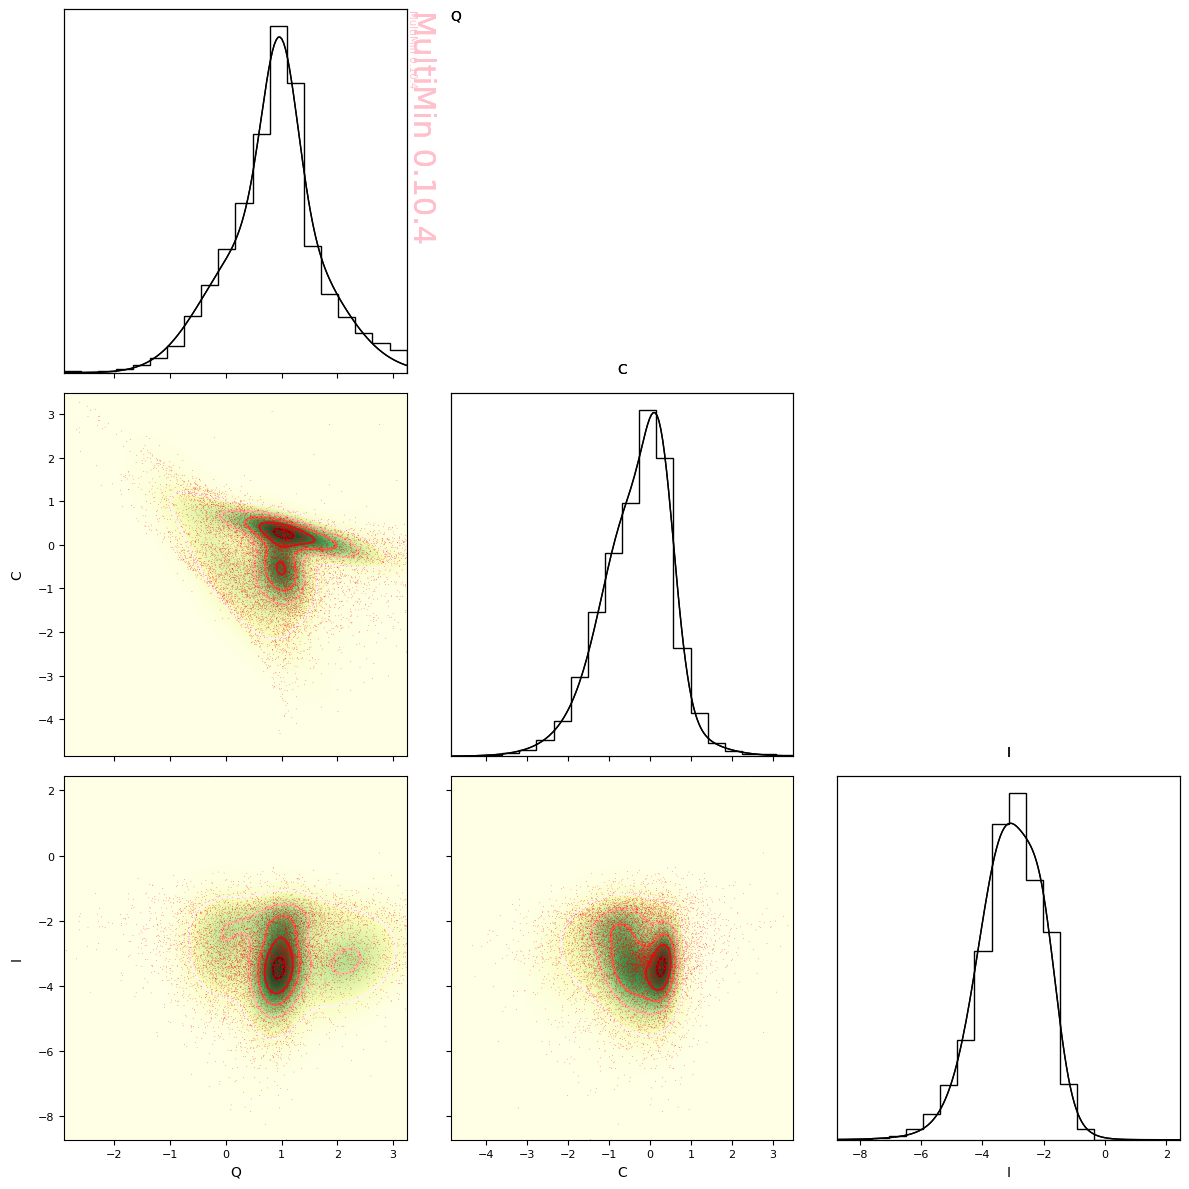

In [39]:
F=mn.FitMoG(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            marginals=True,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted MoG and comparing to the data:

MixtureOfGaussians.rvs executed in 0.6073122024536133 seconds


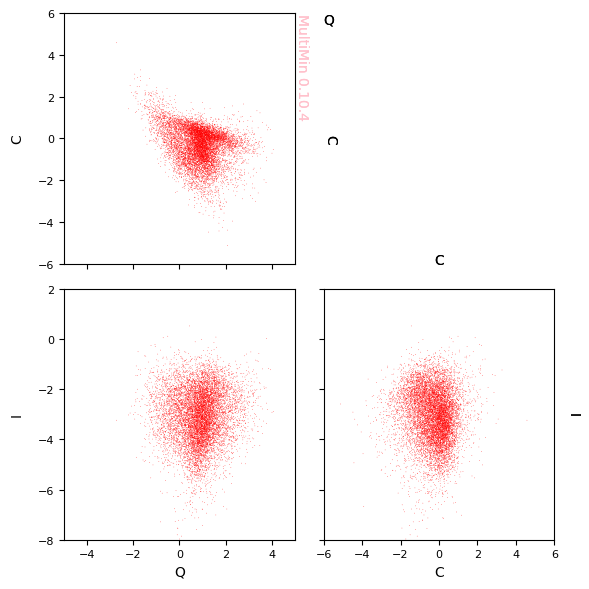

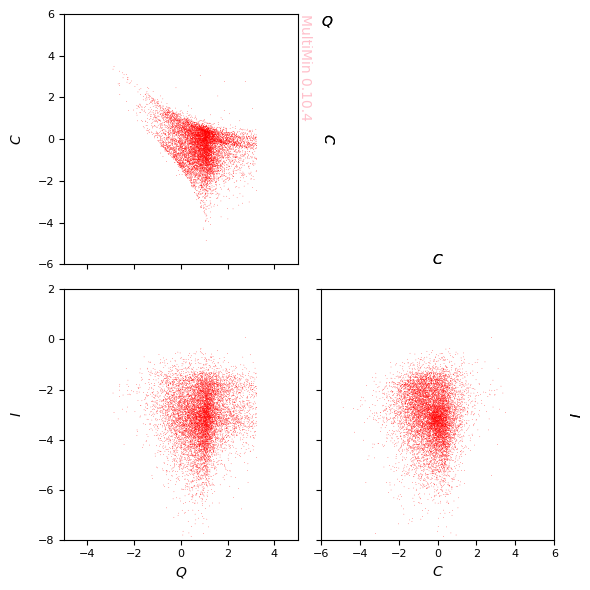

In [40]:
F.mog.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

We can also check the original distribution:

In [39]:
scales=[1.35,1.00,180.0]
usample = F.mog.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

MixtureOfGaussians.rvs executed in 0.49385714530944824 seconds


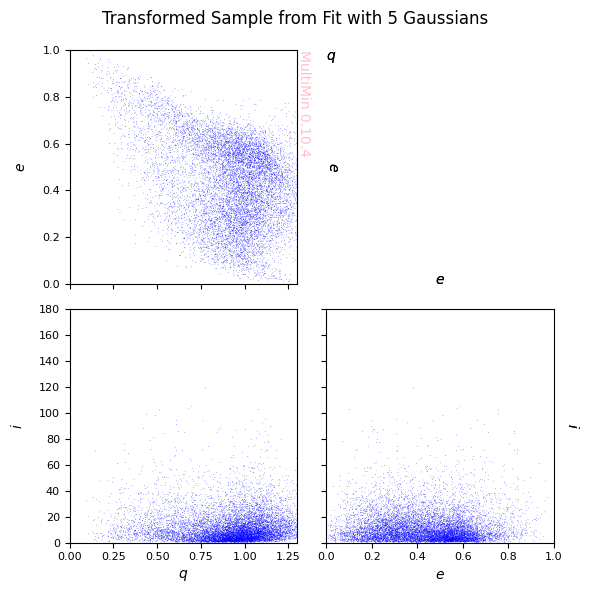

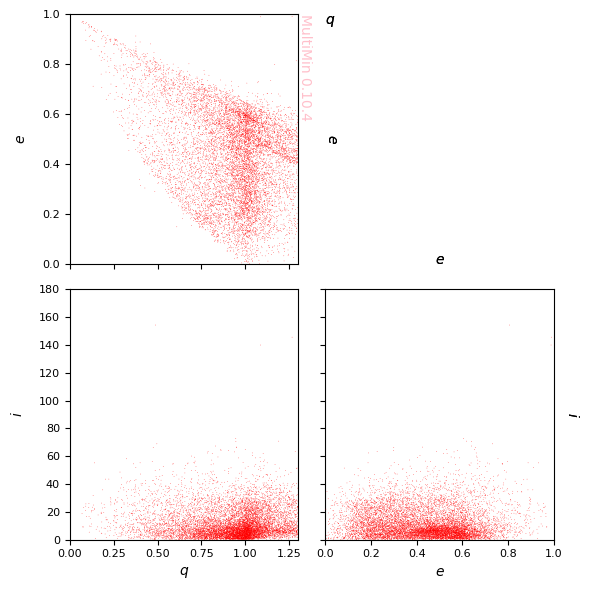

In [40]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.sample_scatter(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.sample_scatter(data_neas_qei,**sargs)

In [41]:
function, mog = F.mog.get_function(properties=properties)

from multimin import Util

def mog(X):

    mu1_q = 0.274465
    mu1_e = 0.402712
    mu1_i = -3.342579
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.374379, -0.33447, -0.158404], [-0.33447, 0.380115, 0.183515], [-0.158404, 0.183515, 1.450391]]
    n1 = Util.nmd(X, mu1, Sigma1)

    mu2_q = 1.457722
    mu2_e = -0.530795
    mu2_i = -2.597881
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.699312, 0.047012, -0.016749], [0.047012, 0.372223, -0.085387], [-0.016749, -0.085387, 0.538708]]
    n2 = Util.nmd(X, mu2, Sigma2)

    mu3_q = 1.08814
    mu3_e = 0.263253
    mu3_i = -3.478693
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.250545, -0.084265, 0.048496], [-0.084265, 0.073813, 0.015997], [0.048496, 0.015997, 1.065472]]
    n3 = Util.nmd(X, mu3, Sigma3)

    mu4_q = 0.014068
    mu4_e = -0.614097
    mu4_i = -2.741746
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.629036, -0.842258, -0.034816], [-0.842258, 1.540873, 0.175419], [-0.034816, 0.175419, 0.880066]]
    n4 = Util.nmd(

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga